In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.autograd import Function
from torchvision import datasets, models, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit.visualization import *

%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Loading Dataset

In [2]:
X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

In [3]:
X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

## Show Data

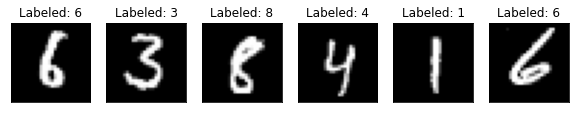

In [4]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

# Setting Quantum Circuit and Hybrid Quantum-Classical Layer

In [5]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        job = qiskit.execute(self._circuit, 
                             self.backend, 
                             shots = self.shots,
                             parameter_binds = [{self.theta: theta} for theta in thetas])
        result = job.result().get_counts(self._circuit)
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [6]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

# Create Hybrid NN

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        self.hybrid1 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.hybrid2 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.fc3 = nn.Linear(2, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x1 = self.hybrid1(x[0][0].reshape(1,-1))
        x2 = self.hybrid2(x[0][1].reshape(1,-1))
        x = torch.cat((x1,x2),-1).float()
        x = self.fc3(x)
        return x

# Train and Validation

In [8]:
def train(model, opimizer, loss_func, train_loader):
    model.train()

    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    #loss_list.append(sum(total_loss)/len(total_loss))

    return sum(total_loss)/len(total_loss)

In [9]:
def validation(model, test_loader):
    model.eval()
    with torch.no_grad():
        total_loss = []
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()
            loss = loss_func(output, target)
            total_loss.append(loss.item())
    loss = sum(total_loss) / len(total_loss)
    acc = correct / len(test_loader) * 100

    return loss, acc

# Training Network

In [10]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
train_loss_list = []
test_loss_list = []
acc_list = []
epochs = 20
for epoch in range(epochs):
    train_loss = train(model,optimizer,loss_func,train_loader)
    train_loss_list.append(train_loss)
    test_loss, acc = validation(model,test_loader)
    acc_list.append(acc)
    test_loss_list.append(test_loss) 
    print('Training [{:.0f}%]\ttrain_Loss: {:.4f}\ttest_acc: {:.1f}%'.format(
        100. * (epoch + 1) / epochs, train_loss,acc))

Training [5%]	train_Loss: 1.2635	test_acc: 62.6%
Training [10%]	train_Loss: 0.8837	test_acc: 80.9%
Training [15%]	train_Loss: 0.6910	test_acc: 86.1%
Training [20%]	train_Loss: 0.5699	test_acc: 90.0%
Training [25%]	train_Loss: 0.5022	test_acc: 94.1%
Training [30%]	train_Loss: 0.4537	test_acc: 95.0%
Training [35%]	train_Loss: 0.4237	test_acc: 95.1%
Training [40%]	train_Loss: 0.3997	test_acc: 95.3%
Training [45%]	train_Loss: 0.3883	test_acc: 95.1%
Training [50%]	train_Loss: 0.3837	test_acc: 95.1%
Training [55%]	train_Loss: 0.3716	test_acc: 94.8%
Training [60%]	train_Loss: 0.3698	test_acc: 96.3%
Training [65%]	train_Loss: 0.3718	test_acc: 95.2%
Training [70%]	train_Loss: 0.3674	test_acc: 95.7%
Training [75%]	train_Loss: 0.3668	test_acc: 95.7%
Training [80%]	train_Loss: 0.3623	test_acc: 96.2%
Training [85%]	train_Loss: 0.3638	test_acc: 94.9%
Training [90%]	train_Loss: 0.3648	test_acc: 95.5%
Training [95%]	train_Loss: 0.3649	test_acc: 94.5%
Training [100%]	train_Loss: 0.3580	test_acc: 95.8%


# Plot Training Graph

Text(0, 0.5, 'Neg Log Likelihood Loss')

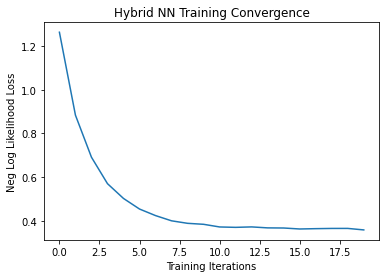

In [11]:
plt.plot(train_loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

# Sigmoid and Tanh

In [12]:
class SNet(nn.Module):
    def __init__(self):
        super(SNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        self.hybrid1 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.hybrid2 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.fc3 = nn.Linear(2, 10)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = self.fc3(x)
        return x

In [17]:
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        self.hybrid1 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.hybrid2 = Hybrid(qiskit.Aer.get_backend('qasm_simulator'), 100, np.pi / 2)
        self.fc3 = nn.Linear(2, 10)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        return x

In [14]:
model = SNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
Strain_loss_list = []
Stest_loss_list = []
Sacc_list = []
epochs = 20
for epoch in range(epochs):
    train_loss = train(model,optimizer,loss_func,train_loader)
    Strain_loss_list.append(train_loss)
    test_loss, acc = validation(model,test_loader)
    Sacc_list.append(acc)
    Stest_loss_list.append(test_loss) 
    print('Training [{:.0f}%]\ttrain_Loss: {:.4f}\ttest_acc: {:.1f}%'.format(
        100. * (epoch + 1) / epochs, train_loss,acc))

Training [5%]	train_Loss: 1.2604	test_acc: 54.4%
Training [10%]	train_Loss: 0.9055	test_acc: 75.9%
Training [15%]	train_Loss: 0.6676	test_acc: 76.8%
Training [20%]	train_Loss: 0.5780	test_acc: 78.2%
Training [25%]	train_Loss: 0.5370	test_acc: 92.9%
Training [30%]	train_Loss: 0.4505	test_acc: 95.9%
Training [35%]	train_Loss: 0.3750	test_acc: 95.8%
Training [40%]	train_Loss: 0.3497	test_acc: 97.0%
Training [45%]	train_Loss: 0.3383	test_acc: 97.0%
Training [50%]	train_Loss: 0.3219	test_acc: 97.0%
Training [55%]	train_Loss: 0.3176	test_acc: 97.4%
Training [60%]	train_Loss: 0.3176	test_acc: 97.3%
Training [65%]	train_Loss: 0.2999	test_acc: 97.0%
Training [70%]	train_Loss: 0.3025	test_acc: 96.6%
Training [75%]	train_Loss: 0.2954	test_acc: 97.0%
Training [80%]	train_Loss: 0.2976	test_acc: 97.6%
Training [85%]	train_Loss: 0.2944	test_acc: 97.0%
Training [90%]	train_Loss: 0.2831	test_acc: 97.4%
Training [95%]	train_Loss: 0.2842	test_acc: 96.6%
Training [100%]	train_Loss: 0.2868	test_acc: 97.5%


Text(0, 0.5, 'Loss')

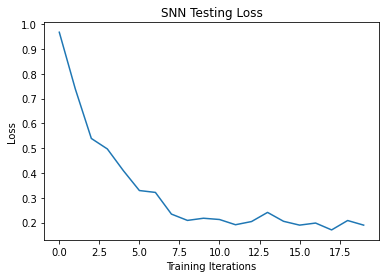

In [15]:
plt.plot(Stest_loss_list)
plt.title('SNN Testing Loss')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')

In [18]:
model = TNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()
Ttrain_loss_list = []
Ttest_loss_list = []
Tacc_list = []
epochs = 20
for epoch in range(epochs):
    train_loss = train(model,optimizer,loss_func,train_loader)
    Ttrain_loss_list.append(train_loss)
    test_loss, acc = validation(model,test_loader)
    Tacc_list.append(acc)
    Ttest_loss_list.append(test_loss) 
    print('Training [{:.0f}%]\ttrain_Loss: {:.4f}\ttest_acc: {:.1f}%'.format(
        100. * (epoch + 1) / epochs, train_loss,acc))

Training [5%]	train_Loss: 1.2066	test_acc: 79.8%
Training [10%]	train_Loss: 0.6805	test_acc: 85.8%
Training [15%]	train_Loss: 0.5405	test_acc: 87.1%
Training [20%]	train_Loss: 0.4589	test_acc: 87.4%
Training [25%]	train_Loss: 0.4387	test_acc: 89.5%
Training [30%]	train_Loss: 0.4302	test_acc: 88.0%
Training [35%]	train_Loss: 0.4182	test_acc: 87.9%
Training [40%]	train_Loss: 0.4141	test_acc: 88.0%
Training [45%]	train_Loss: 0.4172	test_acc: 87.7%
Training [50%]	train_Loss: 0.4094	test_acc: 93.5%
Training [55%]	train_Loss: 0.3862	test_acc: 96.0%
Training [60%]	train_Loss: 0.3328	test_acc: 96.0%
Training [65%]	train_Loss: 0.3324	test_acc: 96.3%
Training [70%]	train_Loss: 0.3392	test_acc: 96.9%
Training [75%]	train_Loss: 0.3130	test_acc: 97.5%
Training [80%]	train_Loss: 0.3177	test_acc: 96.9%
Training [85%]	train_Loss: 0.3220	test_acc: 97.2%
Training [90%]	train_Loss: 0.3108	test_acc: 97.0%
Training [95%]	train_Loss: 0.3137	test_acc: 96.6%
Training [100%]	train_Loss: 0.3163	test_acc: 96.7%


Text(0, 0.5, 'Loss')

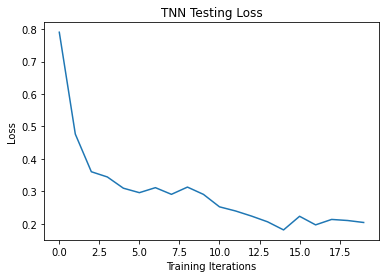

In [19]:
plt.plot(Ttest_loss_list)
plt.title('TNN Testing Loss')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

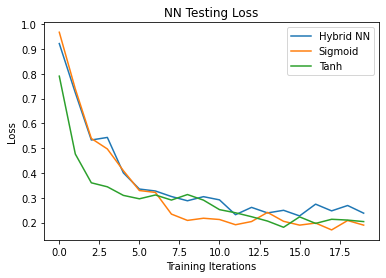

In [20]:
plt.plot(test_loss_list, label='Hybrid NN')
plt.plot(Stest_loss_list, label='Sigmoid')
plt.plot(Ttest_loss_list, label='Tanh')
plt.legend()
plt.title('NN Testing Loss')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

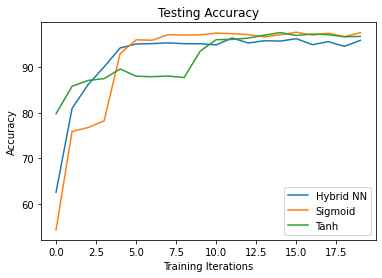

In [21]:
plt.plot(acc_list, label='Hybrid NN')
plt.plot(Sacc_list, label='Sigmoid')
plt.plot(Tacc_list, label='Tanh')
plt.legend()
plt.title('Testing Accuracy')
plt.xlabel('Training Iterations')
plt.ylabel('Accuracy')